In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import tensorflow as tf

In [2]:
from deepgroebner.wrapped import CLeadMonomialsEnv as LeadMonomialsEnv
from deepgroebner.pg import PPOAgent, discount_rewards
from deepgroebner.networks import ParallelMultilayerPerceptron, RecurrentValueModel, PoolingValueModel

## Training Plots

Training speed:
* pool: 12 hours
* rnn: 16.5 hours
* degree: 7 hours

In [3]:
pool = pd.read_csv('data/train/2021-02-27-13-51-26_pool/run-2021-02-27-13-51-26_pool-tag-mean_returns.csv')
rnn = pd.read_csv('data/train/2021-02-27-18-35-46_rnn/run-2021-02-27-18-35-46_rnn-tag-mean_returns.csv')
degree = pd.read_csv('run-seed351-tag-mean_returns.csv')
degree = degree[degree.Step < 2500]

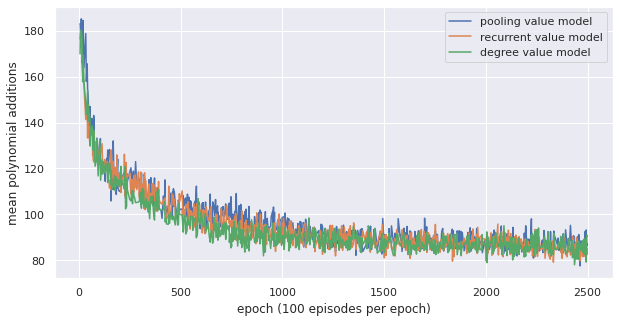

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(pool['Step'], -pool['Value'], label='pooling value model')
plt.plot(rnn['Step'], -rnn['Value'], label='recurrent value model')
plt.plot(degree['Step'], -degree['Value'], label='degree value model')
plt.xlabel('epoch (100 episodes per epoch)')
plt.ylabel('mean polynomial additions')
plt.legend()
plt.savefig('training-othervalue.png', bbox_inches='tight')

## Evaluation

In [5]:
pool = pd.read_csv('data/eval/2021-02-28-16-27-06_pool/results.csv')
rnn = pd.read_csv('data/eval/2021-02-28-16-28-17_rnn/results.csv')
degree = pd.read_csv('results.csv')

In [6]:
pd.DataFrame({"Pool": pool.Return.describe(),
              "RNN": rnn.Return.describe(),
              "Degree": degree.Return.describe()})

,Pool,RNN,Degree
count,10000.000000,10000.000000,10000.000000
mean,-87.802200,-85.643200,-85.768400
std,28.438294,28.111249,27.892887
min,-323.000000,-353.000000,-423.000000
25%,-104.000000,-101.000000,-101.000000
50%,-85.000000,-83.000000,-83.000000
75%,-69.000000,-67.000000,-67.000000
max,-21.000000,-20.000000,-19.000000


## Predicted vs Actual

In [7]:
env = LeadMonomialsEnv('3-20-10-weighted', k=2)

In [8]:
policy_network = ParallelMultilayerPerceptron([128])
value_network = PoolingValueModel([128], [128], 'sum')
pool_agent = PPOAgent(policy_network, value_network=value_network)
pool_agent.act(env.reset())
pool_agent.value(env.reset())
pool_agent.load_policy_weights('data/train/2021-02-27-13-51-26_pool/policy-2500.h5')
pool_agent.load_value_weights('data/train/2021-02-27-13-51-26_pool/value-2500.h5')

In [9]:
policy_network = ParallelMultilayerPerceptron([128])
value_network = RecurrentValueModel(16)
rnn_agent = PPOAgent(policy_network, value_network=value_network)
rnn_agent.act(env.reset())
rnn_agent.value(env.reset())
rnn_agent.load_policy_weights('data/train/2021-02-27-18-35-46_rnn/policy-2500.h5')
rnn_agent.load_value_weights('data/train/2021-02-27-18-35-46_rnn/value-2500.h5')

In [10]:
policy_network = ParallelMultilayerPerceptron([128])
value_network = 'degree'
degree_agent = PPOAgent(policy_network, value_network=value_network)
degree_agent.act(env.reset())
degree_agent.load_policy_weights('policy.h5')

In [11]:
def run_episode(agent, env):
    state = env.reset()
    done = False
    values, rewards = [], []
    while not done:
        action = agent.act(state)
        value = env.value('degree') if agent.value_model == 'degree' else agent.value(state).numpy()
        state, reward, done, _ = env.step(action)
        values.append(value)
        rewards.append(reward)
    return values, rewards

In [12]:
def plot_comparison(agent, seeds):
    for seed in seeds:
        env.seed(seed)
        values, rewards = run_episode(agent, env)
        plt.scatter(discount_rewards(rewards, 0.99), np.array(values), c='b', s=5)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),
        np.max([plt.xlim(), plt.ylim()]),
    ]
    lims = [-150, 0]
    plt.plot(lims, lims, 'k')
    plt.xlabel('actual future return')
    plt.ylabel('predicted future return')

In [13]:
np.random.seed(123)
seeds = np.random.randint(10000, size=50)

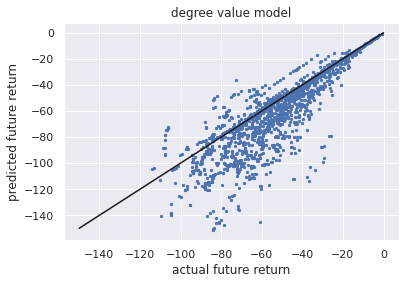

In [14]:
plot_comparison(degree_agent, seeds)
plt.title('degree value model');
plt.savefig('degree-value.png', bbox_inches='tight')

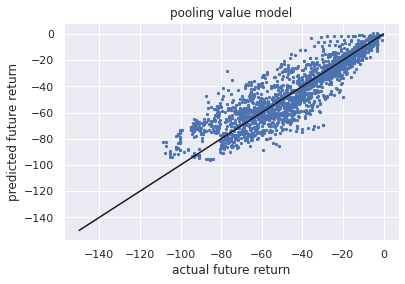

In [15]:
plot_comparison(pool_agent, seeds)
plt.title('pooling value model');
plt.savefig('pooling-value.png', bbox_inches='tight')

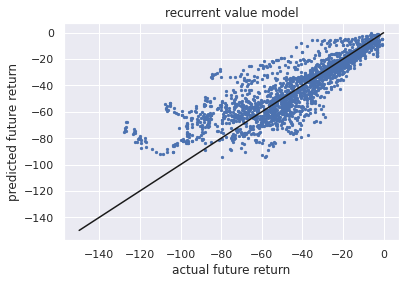

In [16]:
plot_comparison(rnn_agent, seeds)
plt.title('recurrent value model');
plt.savefig('recurrent-value.png', bbox_inches='tight')